In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np

# internal imports
from tgb.utils.utils import *
from tgb.linkproppred.evaluate import Evaluator
from modules.decoder import LinkPredictorTGNPL
from modules.emb_module import GraphAttentionEmbedding
from modules.msg_func import TGNPLMessage
from modules.msg_agg import MeanAggregator
from modules.neighbor_loader import LastNeighborLoaderTGNPL
from modules.memory_module import TGNPLMemory, StaticMemory
from modules.early_stopping import  EarlyStopMonitor
from modules.hyper_edgebank import HyperEdgeBankPredictor, test_edgebank
from tgb.linkproppred.dataset_pyg import PyGLinkPropPredDataset, PyGLinkPropPredDatasetHyper
from tgnpl import *

# Results from full experiments

In [29]:
import matplotlib.pyplot as plt 

def plot_train_loss_and_val_mrr(results):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
    fig.subplots_adjust(wspace=0.3)
    ax = axes[0]
    ax.plot(results['train loss'])
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Train loss', fontsize=12)
    ax.set_yscale('symlog')
    ax.grid(alpha=0.2)

    ax = axes[1]
    ax.plot(results['val mrr'])
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Val MRR', fontsize=12)
    ax.grid(alpha=0.2)
    return fig, axes

Min train loss = 2.0597, best val mrr = 0.2331 (train loss = 944.9884), test mrr = 0.2287


Text(0.5, 0.98, 'GNN + static memory')

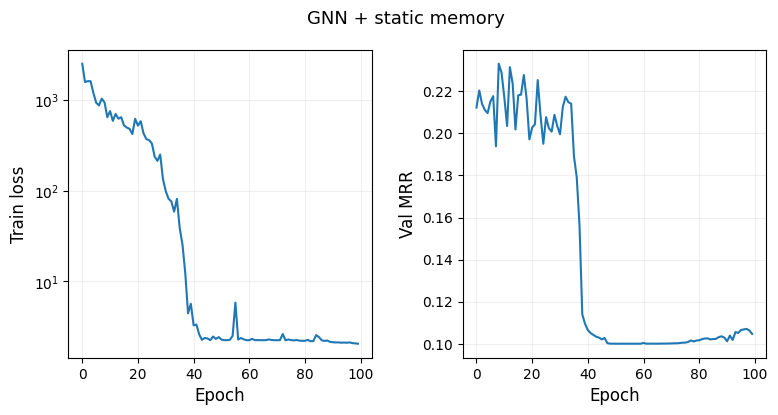

In [30]:
# static, mostly default settings, BCE criterion
fn = 'TGNPL_tgbl-hypergraph_0.0001_200_10_100_1_100_10_100_1e-06_100.0_1_10_static_False_0_0_2023_09_05-14_14_02_results.json'
fn = os.path.join('saved_results', fn)
with open(fn, 'r') as f:
    results = json.load(f)
train_loss, val_mrr, test_mrr = results['train loss'], results['val mrr'], results['test mrr']
print('Min train loss = %.4f, best val mrr = %.4f (train loss = %.4f), test mrr = %.4f' % (
    min(train_loss), max(val_mrr), train_loss[np.argmax(val_mrr)], test_mrr))
fig, axes = plot_train_loss_and_val_mrr(results)
fig.suptitle('GNN + static memory', fontsize=13)

Min train loss = 1.3828, best val mrr = 0.2269 (train loss = 1345.8838), test mrr = 0.2237


Text(0.5, 0.98, 'GNN + static memory, cross-entropy')

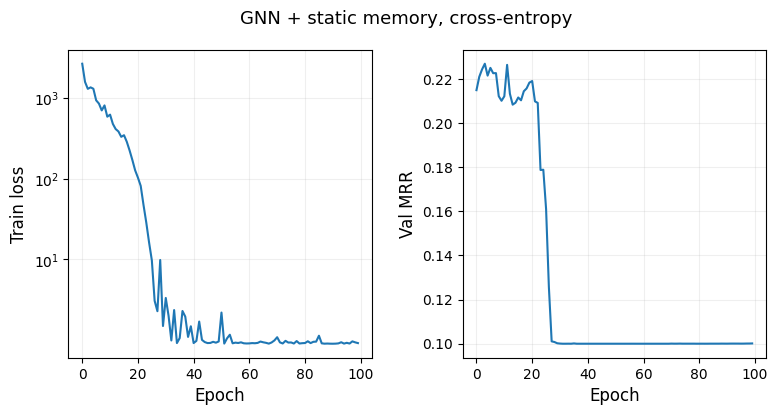

In [31]:
# static, mostly default settings, softmax cross-entropy criterion
fn = 'TGNPL_tgbl-hypergraph_0.0001_200_10_100_1_100_10_100_1e-06_100.0_1_10_static_False_0_0_2023_09_06-11_46_26_results.json'
fn = os.path.join('saved_results', fn)
with open(fn, 'r') as f:
    results = json.load(f)
train_loss, val_mrr, test_mrr = results['train loss'], results['val mrr'], results['test mrr']
print('Min train loss = %.4f, best val mrr = %.4f (train loss = %.4f), test mrr = %.4f' % (
    min(train_loss), max(val_mrr), train_loss[np.argmax(val_mrr)], test_mrr))
fig, axes = plot_train_loss_and_val_mrr(results)
fig.suptitle('GNN + static memory, cross-entropy', fontsize=13)

## What did the model learn?

In [2]:
# recreate args
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
args = Namespace(dataset='tgbl-hypergraph',
                 lr=1e-4,
                 bs=2000,  # use larger batch size since we're not training
                 k_value=10,
                 num_epoch=100,
                 seed=1,
                 mem_dim=100,
                 time_dim=10,
                 emb_dim=100,
                 tolerance=1e-6,
                 patience=100,
                 num_run=1,
                 wandb=False,
                 bipartite=False,
                 memory_name='static',
                 use_inventory=False,
                 debt_penalty=0,
                 consum_rwd=0,
                 gpu=0)
device = torch.device("cpu")

In [3]:
# Initialize dataset - copied from run_experiment() in tgnpl.py
with open(os.path.join(PATH_TO_DATASETS, f"{args.dataset.replace('-', '_')}/{args.dataset}_meta.json"), "r") as f:
    metadata = json.load(f)
# set global data variables
num_nodes = len(metadata["id2entity"])  
num_firms = metadata["product_threshold"]
num_products = num_nodes - num_firms              
dataset = PyGLinkPropPredDatasetHyper(name=args.dataset, root="datasets")
metric = dataset.eval_metric
neg_sampler = dataset.negative_sampler
evaluator = Evaluator(name=args.dataset)

# split into train/val/test
data = dataset.get_TemporalData().to(device)
train_loader = TemporalDataLoader(data[dataset.train_mask], batch_size=args.bs)
val_loader = TemporalDataLoader(data[dataset.val_mask], batch_size=args.bs)
test_loader = TemporalDataLoader(data[dataset.test_mask], batch_size=args.bs)

dataset.load_val_ns()  # load validation negative samples

Dataset tgbl-hypergraph url not found, download not supported yet.
file found, skipping download
Dataset directory is  /lfs/turing1/0/serinac/supply-chains/TGB/tgb/datasets/tgbl_hypergraph
loading processed file


In [4]:
# initialize edgebank, fit on train
edgebank = HyperEdgeBankPredictor(num_firms, num_products, consecutive=True)
train_data = data[dataset.train_mask]
edgebank.fit(train_data.src, train_data.dst, train_data.prod)

Fit on 214674 edges; found 38756 unique


In [5]:
test_edgebank(val_loader, neg_sampler, "val", evaluator, metric, edgebank, use_counts=False)

100%|█████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 25.36it/s]


0.3399311602115631

In [6]:
test_edgebank(val_loader, neg_sampler, "val", evaluator, metric, edgebank, use_counts=True)

100%|█████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.41it/s]


0.6819248199462891

### Try final model with low train loss

In [7]:
# Initialize model, load saved weights
model, opt = set_up_model(args, data, device, num_nodes=num_nodes, num_products=num_products)
# load saved model - final model with low training loss
model_path = 'TGNPL_tgbl-hypergraph_0.0001_200_10_100_1_100_10_100_1e-06_100.0_1_10_static_False_0_0_2023_09_05-14_14_02_0_final.pth'
model_path = os.path.join('saved_models', model_path)
checkpoint = torch.load(model_path)
for module_name, module in model.items():
    module.load_state_dict(checkpoint[module_name])
    
neighbor_loader = LastNeighborLoaderTGNPL(num_nodes, size=NUM_NEIGHBORS, device=device)

In [8]:
# run the model through train loader *without* updating model weights
# this is so that we can update model memory and neighbor loader with train data
# and to verify that the train loss is low
train(model, _, neighbor_loader, data, train_loader, device, loss_name='bce-logits',
      update_params=False, num_nodes=num_nodes, num_firms=num_firms, num_products=num_products)

100%|███████████████████████████████████████████████████████████████████████| 108/108 [01:20<00:00,  1.35it/s]


(2.2241699868197795, 2.2241699868197795, 0.0)

In [10]:
# test model on first batch of val loader
# copied from test() in tgnpl.py
model['memory'].eval()
model['gnn'].eval()
model['link_pred'].eval()
assoc = torch.empty(num_nodes, dtype=torch.long, device=device)

pos_batch = next(iter(val_loader))
pos_src, pos_prod, pos_dst, pos_t, pos_msg = (
    pos_batch.src,
    pos_batch.prod,
    pos_batch.dst,
    pos_batch.t,
    pos_batch.msg,
)
bs = len(pos_src)  # batch size

neg_batch_list = neg_sampler.query_batch(pos_src, pos_prod, pos_dst, pos_t, split_mode='val')
assert len(neg_batch_list) == bs
neg_batch_list = torch.Tensor(neg_batch_list)
ns_samples = neg_batch_list.size(1) // 3 
batch_src = pos_src.reshape(bs, 1).repeat(1, 1+(3*ns_samples))  # [[src1, src1, ...], [src2, src2, ...]]
batch_src[:, 1:ns_samples+1] = neg_batch_list[:, :ns_samples]  # replace pos_src with negatives
batch_prod = pos_prod.reshape(bs, 1).repeat(1, 1+(3*ns_samples))
batch_prod[:, ns_samples+1:(2*ns_samples)+1] = neg_batch_list[:, ns_samples:(2*ns_samples)]  # replace pos_prod with negatives
batch_dst = pos_dst.reshape(bs, 1).repeat(1, 1+(3*ns_samples))
batch_dst[:, (2*ns_samples)+1:] = neg_batch_list[:, (2*ns_samples):]  # replace pos_dst with negatives
src, dst, prod = batch_src.flatten(), batch_dst.flatten(), batch_prod.flatten()  # row-wise

# Get GNN prediction
f_id = torch.cat([src, dst]).unique()
p_id = torch.cat([prod]).unique()
n_id, edge_index, e_id = neighbor_loader(f_id, p_id)
assoc[n_id] = torch.arange(n_id.size(0), device=device)
# Get updated memory of all nodes involved in the computation.
memory, last_update, inv_loss = model['memory'](n_id)
z = model['gnn'](
    memory,
    last_update,
    edge_index,
    repeat_tensor(data.t, 2)[e_id].to(device),
    repeat_tensor(data.msg, 2)[e_id].to(device),
)
y_pred_gnn = model['link_pred'](z[assoc[src]], z[assoc[dst]], z[assoc[prod]])
y_pred = y_pred_gnn.reshape(bs, 1+(3*ns_samples))
input_dict = {
    "y_pred_pos": y_pred[:, :1],
    "y_pred_neg": y_pred[:, 1:],
    "eval_metric": [metric]
}
print('GNN MRR:', evaluator.eval(input_dict)[metric])

# Get Edgebank prediction
y_pred_eb = edgebank.predict(src, dst, prod, use_counts=True)
y_pred = y_pred_eb.reshape(bs, 1+(3*ns_samples))
input_dict = {
    "y_pred_pos": y_pred[:, :1],
    "y_pred_neg": y_pred[:, 1:],
    "eval_metric": [metric]
}
print('EdgeBank MRR:', evaluator.eval(input_dict)[metric])

GNN MRR: 0.104181096
EdgeBank MRR: 0.69496816


In [11]:
from scipy.stats import spearmanr

y_pred_gnn = y_pred_gnn.detach().numpy()
y_pred_eb = y_pred_eb.detach().numpy()
print(y_pred_gnn.shape)
print('Spearman correlation', spearmanr(y_pred_gnn, y_pred_eb))
print(y_pred_gnn[:10])

(38000, 1)
Spearman correlation SpearmanrResult(correlation=0.0576111721834171, pvalue=2.610014425769743e-29)
[[-0.8352514]
 [-0.8352514]
 [-0.8352514]
 [-0.8352514]
 [-0.8352514]
 [-0.8352514]
 [-0.8352514]
 [-0.8352514]
 [-0.8352514]
 [-0.8352514]]


In [12]:
y_pred_eb[:10]

array([11.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  1.], dtype=float32)

### Try best model with highest val MRR

In [13]:
# load saved model - model with highest MRR
model_path = 'TGNPL_tgbl-hypergraph_0.0001_200_10_100_1_100_10_100_1e-06_100.0_1_10_static_False_0_0_2023_09_05-14_14_02_0.pth'
model_path = os.path.join('saved_models', model_path)
checkpoint = torch.load(model_path)
for module_name, module in model.items():
    module.load_state_dict(checkpoint[module_name])
    
neighbor_loader = LastNeighborLoaderTGNPL(num_nodes, size=NUM_NEIGHBORS, device=device)

In [14]:
# run the model through train loader *without* updating model weights
# this is so that we can update model memory and neighbor loader with train data
# and to verify that the train loss is much higher
train(model, _, neighbor_loader, data, train_loader, device, loss_name='bce-logits',
      update_params=False, num_nodes=num_nodes, num_firms=num_firms, num_products=num_products)

100%|███████████████████████████████████████████████████████████████████████| 108/108 [01:33<00:00,  1.16it/s]


(345.256700752653, 345.256700752653, 0.0)

In [15]:
# Get GNN prediction
f_id = torch.cat([src, dst]).unique()
p_id = torch.cat([prod]).unique()
n_id, edge_index, e_id = neighbor_loader(f_id, p_id)
assoc[n_id] = torch.arange(n_id.size(0), device=device)
# Get updated memory of all nodes involved in the computation.
memory, last_update, inv_loss = model['memory'](n_id)
z = model['gnn'](
    memory,
    last_update,
    edge_index,
    repeat_tensor(data.t, 2)[e_id].to(device),
    repeat_tensor(data.msg, 2)[e_id].to(device),
)
y_pred_gnn = model['link_pred'](z[assoc[src]], z[assoc[dst]], z[assoc[prod]])
y_pred = y_pred_gnn.reshape(bs, 1+(3*ns_samples))
input_dict = {
    "y_pred_pos": y_pred[:, :1],
    "y_pred_neg": y_pred[:, 1:],
    "eval_metric": [metric]
}
print('GNN MRR:', evaluator.eval(input_dict)[metric])  # should be higher than before

# Get Edgebank prediction
y_pred_eb = edgebank.predict(src, dst, prod, use_counts=True)
y_pred = y_pred_eb.reshape(bs, 1+(3*ns_samples))
input_dict = {
    "y_pred_pos": y_pred[:, :1],
    "y_pred_neg": y_pred[:, 1:],
    "eval_metric": [metric]
}
print('EdgeBank MRR:', evaluator.eval(input_dict)[metric])  # should be the same as before

GNN MRR: 0.22699822
EdgeBank MRR: 0.69496816


In [16]:
from scipy.stats import spearmanr

y_pred_gnn = y_pred_gnn.detach().numpy()
y_pred_eb = y_pred_eb.detach().numpy()
print(y_pred_gnn.shape)
print('Spearman correlation', spearmanr(y_pred_gnn, y_pred_eb))
print(y_pred_gnn[:10])

(38000, 1)
Spearman correlation SpearmanrResult(correlation=0.16916034598167873, pvalue=6.769444725066205e-242)
[[-1406.6364 ]
 [-2458.574  ]
 [-2461.6873 ]
 [-1911.2262 ]
 [-2617.1443 ]
 [-2453.531  ]
 [-2464.6873 ]
 [-1370.6754 ]
 [-1371.9606 ]
 [ -726.79846]]


### Test loss

In [19]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = -0.8352514
sigx = sigmoid(x)
print('sigmoid x:', sigx)

pos_l = -np.log(sigx)
print('loss if positive', pos_l)

neg_l = -np.log(1-sigx)
print('loss if negative', neg_l)

total = pos_l + (3*neg_l)
print('expected total loss from batch', total)

sigmoid x: 0.30253583558385383
loss if positive 1.1955555437876215
loss if negative 0.36030414378762143
expected total loss from batch 2.276467975150486


In [21]:
ce_loss = torch.nn.CrossEntropyLoss()
ce_loss(torch.tensor([[x, x, x, x]]), torch.tensor([0]).long())

tensor(1.3863)

In [25]:
# same if you use any equal number
ce_loss(torch.ones((1, 4)), torch.tensor([0]).long())

tensor(1.3863)

In [26]:
for c in range(4, 20):
    print(c, ce_loss(torch.ones((1, c)), torch.tensor([0]).long()))

4 tensor(1.3863)
5 tensor(1.6094)
6 tensor(1.7918)
7 tensor(1.9459)
8 tensor(2.0794)
9 tensor(2.1972)
10 tensor(2.3026)
11 tensor(2.3979)
12 tensor(2.4849)
13 tensor(2.5649)
14 tensor(2.6391)
15 tensor(2.7081)
16 tensor(2.7726)
17 tensor(2.8332)
18 tensor(2.8904)
19 tensor(2.9444)


In [27]:
# double, four classes
ce_loss(torch.tensor([[2., 1., 1., 1.]]), torch.tensor([0]).long())

tensor(0.7437)

In [28]:
# half, four classes
ce_loss(torch.tensor([[0.5, 1., 1., 1.]]), torch.tensor([0]).long())

tensor(1.7827)

### Try final model from cross-entropy experiment

In [32]:
# load saved model
model_path = 'TGNPL_tgbl-hypergraph_0.0001_200_10_100_1_100_10_100_1e-06_100.0_1_10_static_False_0_0_2023_09_06-11_46_26_0_final.pth'
model_path = os.path.join('saved_models', model_path)
checkpoint = torch.load(model_path)
for module_name, module in model.items():
    module.load_state_dict(checkpoint[module_name])
    
neighbor_loader = LastNeighborLoaderTGNPL(num_nodes, size=NUM_NEIGHBORS, device=device)

In [33]:
# run the model through train loader *without* updating model weights
# this is so that we can update model memory and neighbor loader with train data
# and to verify that the train loss is much higher
train(model, _, neighbor_loader, data, train_loader, device, loss_name='ce-softmax',
      update_params=False, num_nodes=num_nodes, num_firms=num_firms, num_products=num_products)

100%|███████████████████████████████████████████████████████████████████████| 108/108 [01:11<00:00,  1.51it/s]


(1.3821909806848687, 1.3821909806848687, 0.0)

In [34]:
# Get GNN prediction
f_id = torch.cat([src, dst]).unique()
p_id = torch.cat([prod]).unique()
n_id, edge_index, e_id = neighbor_loader(f_id, p_id)
assoc[n_id] = torch.arange(n_id.size(0), device=device)
# Get updated memory of all nodes involved in the computation.
memory, last_update, inv_loss = model['memory'](n_id)
z = model['gnn'](
    memory,
    last_update,
    edge_index,
    repeat_tensor(data.t, 2)[e_id].to(device),
    repeat_tensor(data.msg, 2)[e_id].to(device),
)
y_pred_gnn = model['link_pred'](z[assoc[src]], z[assoc[dst]], z[assoc[prod]])
y_pred = y_pred_gnn.reshape(bs, 1+(3*ns_samples))
input_dict = {
    "y_pred_pos": y_pred[:, :1],
    "y_pred_neg": y_pred[:, 1:],
    "eval_metric": [metric]
}
print('GNN MRR:', evaluator.eval(input_dict)[metric])  # should be higher than before

# Get Edgebank prediction
y_pred_eb = edgebank.predict(src, dst, prod, use_counts=True)
y_pred = y_pred_eb.reshape(bs, 1+(3*ns_samples))
input_dict = {
    "y_pred_pos": y_pred[:, :1],
    "y_pred_neg": y_pred[:, 1:],
    "eval_metric": [metric]
}
print('EdgeBank MRR:', evaluator.eval(input_dict)[metric])  # should be the same as before

GNN MRR: 0.1001942
EdgeBank MRR: 0.69496816


In [35]:
from scipy.stats import spearmanr

y_pred_gnn = y_pred_gnn.detach().numpy()
y_pred_eb = y_pred_eb.detach().numpy()
print(y_pred_gnn.shape)
print('Spearman correlation', spearmanr(y_pred_gnn, y_pred_eb))
print(y_pred_gnn[:10])

(38000, 1)
Spearman correlation SpearmanrResult(correlation=0.023991311286992563, pvalue=2.9069547426294575e-06)
[[-1.9877135]
 [-1.9877135]
 [-1.9877135]
 [-1.9877135]
 [-1.9877135]
 [-1.9877135]
 [-1.9877135]
 [-1.9877135]
 [-1.9877135]
 [-1.9877135]]


In [36]:
y_pred_eb[:10]

array([11.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  1.], dtype=float32)